In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from collections import defaultdict 

In [2]:
def parse_accs(fname):
    f_string = ''
    with open(fname, 'r') as f:
        for line in f.readlines():
            f_string += (f' {line}')

    perfs = f_string.split('[random_search]')
    perfs = list(filter(lambda s: 'conf=' in s, perfs))
    perf_dict = defaultdict(list)
    for p in perfs:
        s = p.strip().split(',')
        s = [item.strip() for item in s]
        conf = s[0].replace('conf=', '')
        seed = int(s[1].replace('seed=', ''))
        acc = float(s[2].replace('acc=', ''))
        perf_dict[conf].append(acc)

    means = []
    stds = []
    points = []
    confs = []
    for k in perf_dict.keys():
        means.append(np.mean(perf_dict[k]))
        stds.append(np.std(perf_dict[k]))
        points.append(perf_dict[k])
        confs.append(k)

    return means, stds, points, confs
    
means, stds, points, confs = parse_accs('results/random_search.log')

In [3]:
points[np.argmax(means)]

[0.3821, 0.4397, 0.4321]

In [4]:
h = confs[np.argmax(means)]
h

'[5.92212138e-02 1.11815863e-01 1.28464862e-01 8.48805478e-02\n  4.19379279e-04 4.04951095e-02 2.02454160e-02 5.72815361e-02\n  4.97176072e-01]'

In [5]:
np.max(means)

0.41796666666666665

In [6]:
len(means)

253

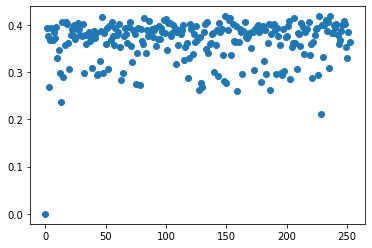

In [7]:
plt.scatter(np.arange(len(means)), means)


In [8]:
rs = []
for i in range(len(means)):
    rs.append(np.max(means[:i+1]))

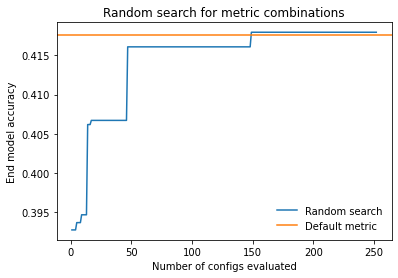

In [10]:
plt.plot(np.arange(1, len(means)), rs[1:], color='C0', label='Random search')
plt.xlabel('Number of configs evaluated')
plt.ylabel('End model accuracy')
plt.title('Random search for metric combinations')
plt.axhline(0.417566667, color='C1', label='Default metric')
plt.legend(frameon=False)
plt.show()